#### 9

In [1]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: svMisc

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [3]:
library(data.table)
library(hts)  


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [4]:
df_eu  <-  read.csv(file="../data_hts/hts_rus_summed.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000
var_freq  <- 12    
var_start_year  <- 2006      
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [5]:
var_h  <- 24
var_window  <-  84 - 1
var_topup  <-  -1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [6]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_drift   <-  FALSE
var_constant   <-  FALSE
var_ets  <- "AAA"
var_damped  <- TRUE

var_char  <-  c(4,2)

In [7]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)
var_countries  <-  dim(read.csv(file="../clustering/hts_rus_summed_state.csv", header=TRUE, sep=",", row.names =1 ))[2]+1
this_file_models_list  <-  list()
this_model_list  <-  list()


In [8]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- ets(msts(allts[,j], seasonal.periods = var_freq), lambda=NULL)
        
    }
    
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(rep(0, var_countries), rep(1, (ncol(allts)-var_countries) )))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)     
    }
this_file_models_list[[1]]  <-  this_model_list



[1]   1  84  85 108
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 80 320 
Total number of series: 401 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -22393.8808  -2187.0157  -5057.8572  -4715.6163  -7959.5631   3760.8284
 [7]  13120.0814  16927.2311  15402.7982   9922.2496   4385.3903   2846.6914
[13] -19387.3378    760.3982  -2167.7847  -1882.7824  -5182.2003   6483.8681
[19]  15790.1326  19545.0810  17969.0612  12438.4594   6851.8774   5265.0147
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 80 320 
Total number of series: 401 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100

In [9]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [10]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [11]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [12]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -23204.1625 -24331.2091 -24076.0792 -24757.1303 -11785.8923   2426.2691
 [7]   -508.2093  -3836.5163  -6649.1785 -12358.7543 -15726.7219 -37831.6880
[13] -23204.1625 -24331.2091 -24076.0792 -24757.1303 -11785.8923   2426.2691
[19]   -508.2093  -3836.5163  -6649.1785 -12358.7543 -15726.7219 -37831.6880

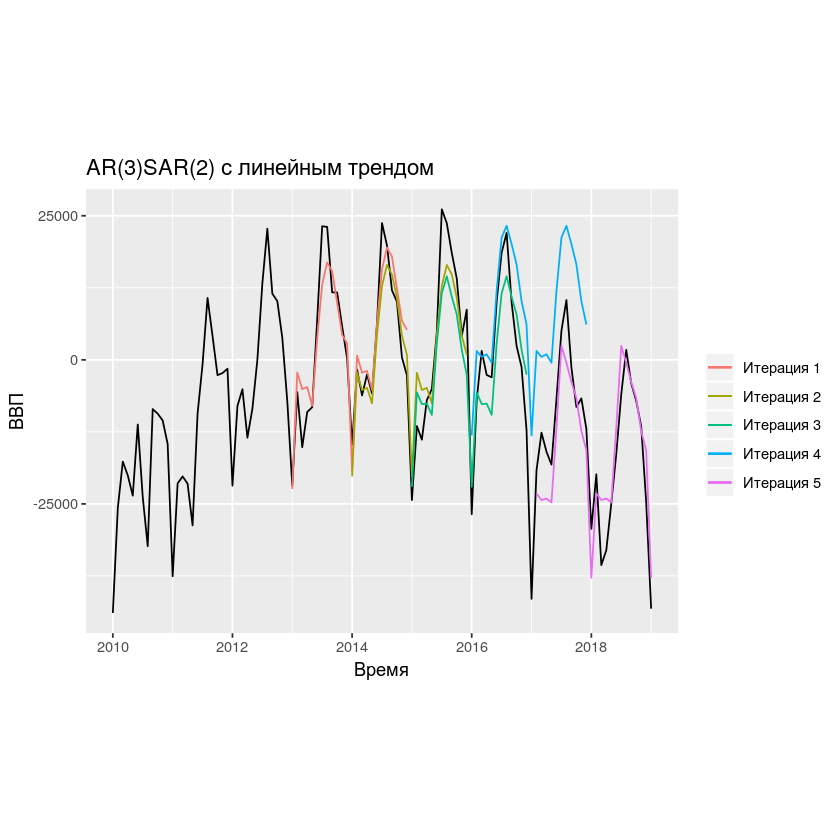

In [13]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [14]:
df_acc

ME,RMSE,MAPE,Iteration
-784.8802,4834.426,145.81385,1
1099.0539,5423.107,75.20995,13
2462.7890,6723.833,97.56190,25
-13027.2251,15174.338,240.41389,37
974.7541,6319.375,50.48171,50


In [15]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-1855.1017  7695.0160   121.8963    25.2000

In [16]:
df_mean_acc <- readRDS("df_mean_acc_noweights.rds")


,Квартальные,Сезонно сглаженные,Месячные
1 level,85.57111,309.7325,8015.222
3 level,85.22093,308.4589,NA
2 level (state),85.22638,308.5041,NA
2 level (type),84.82532,305.0175,NA
2 level (clusetered),85.17063,303.3762,NA


In [17]:
df_mean_acc[2,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,85.57111,309.7325,8015.222
3 level,85.22093,308.4589,7695.016
2 level (state),85.22638,308.5041,NA
2 level (type),84.82532,305.0175,NA
2 level (clusetered),85.17063,303.3762,NA


In [18]:
df_acc

ME,RMSE,MAPE,Iteration
-784.8802,4834.426,145.81385,1
1099.0539,5423.107,75.20995,13
2462.7890,6723.833,97.56190,25
-13027.2251,15174.338,240.41389,37
974.7541,6319.375,50.48171,50


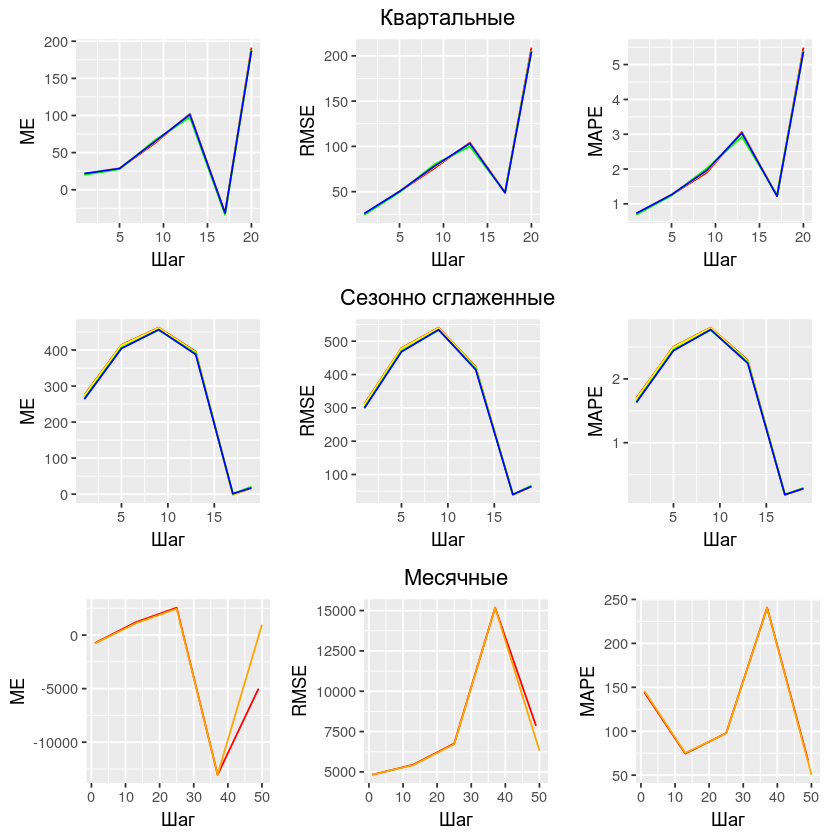

In [19]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all_noweights.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 state

In [20]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_state.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [21]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [22]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [23]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- ets(msts(allts[,j], seasonal.periods = var_freq), lambda=NULL)
        
    }
    
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }
this_file_models_list[[2]]  <-  this_model_list


[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -22392.1189  -2176.5729  -5060.3246  -4708.7627  -7959.9815   3763.9564
 [7]  13115.3737  16923.3749  15409.4508   9916.2171   4387.1945   2845.4599
[13] -19390.7320    765.5853  -2176.1466  -1881.4931  -5188.4145   6480.9525
[19]  15778.9725  19534.6734  17969.4116  12425.8164   6847.3799   5257.2385
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 12

Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -20188.1425  -2199.8089  -5187.4749  -4810.5058  -7491.4948   4428.3830
 [7]  12872.2077  16538.5638  14892.2304  10851.0209   4281.5230    976.4721
[13] -20136.4674  -2148.2191  -5135.9685  -4759.0812  -7440.1502   4479.6492
[19]  12923.3972  16589.6783  14943.2714  10901.9898   4332.4215   1027.3016
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -24328 -11496 -13858  -6986  -5066   4880  26123  23705
[21]  18556  14103   4114   8705
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21991.954  -5606.684  -7626.241  -7540.501  -9496.419   2889.642
 [7]  11612.918  14555.462  11002.879   7937.328   1835.093  -2507.527
[13] -21965.434  -5580.235  -7599.896  -7514.274  -9470.358   2915.601
[19]  11638.818  14581.243  11028.533   7962.942   1860.534  -2482.126
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -24328 -11496 -13858  -6986  -5066   4880  26123  23705  18556  14103
[11]   4114   8705 -26799  -6998   1542  -2629  -3031  10067  18591  22017
[21]  10026   2420  -1256 -12220
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -13143.4160   1530.5688    506.1624    941.0211   -503.4592  11961.6881
 [7]  21194.3197  23232.9298  20094.2002  16524.3794  10160.7281   6123.5114
[13] -13134.4586   1539.4681    515.0533    949.9134   -494.5080  11970.6194
[19]  21203.1656  23241.8045  20103.0906  16533.1996  10169.6490   6132.3717
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -26799  -6998   1542  -2629  -3031  10067  18591  22017  10026   2420
[11]  -1256 -12220 -41475 -19176 -12642 -15942 -18179  -6838   5045  10369
[21]  -1320  -8177  -6696 -12005
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -23143.2216 -24260.0957 -24008.0299 -24686.5192 -11717.6250   2477.4928
 [7]   -444.2177  -3776.4761  -6589.8340 -12295.5358 -15662.7679 -37767.7629
[13] -23148.3861 -24265.9152 -24013.7775 -24692.3739 -11723.6746   2470.8051
[19]   -450.9418  -3782.7255  -6596.1697 -12301.3740 -15668.6987 -37772.8112
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19176 -12642 -15942 -18179  -6838   5045  10369  -1320  -8177  -6696
[11] -12005 -29346 -19876 -35619 -33053 -24949 -16354  -5987   1730  -4072
[21]  -7117 -11516 -24655 -43180


In [24]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [25]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [26]:
df_acc

ME,RMSE,MAPE,Iteration
-782.8546,4835.243,145.75499,1
1112.3418,5428.569,75.11954,13
2489.2773,6734.310,97.63515,25
-13027.4168,15173.183,240.46399,37
1011.0682,6323.692,50.68303,50


In [27]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -23204.1625 -24331.2091 -24076.0792 -24757.1303 -11785.8923   2426.2691
 [7]   -508.2093  -3836.5163  -6649.1785 -12358.7543 -15726.7219 -37831.6880
[13] -23204.1625 -24331.2091 -24076.0792 -24757.1303 -11785.8923   2426.2691
[19]   -508.2093  -3836.5163  -6649.1785 -12358.7543 -15726.7219 -37831.6880

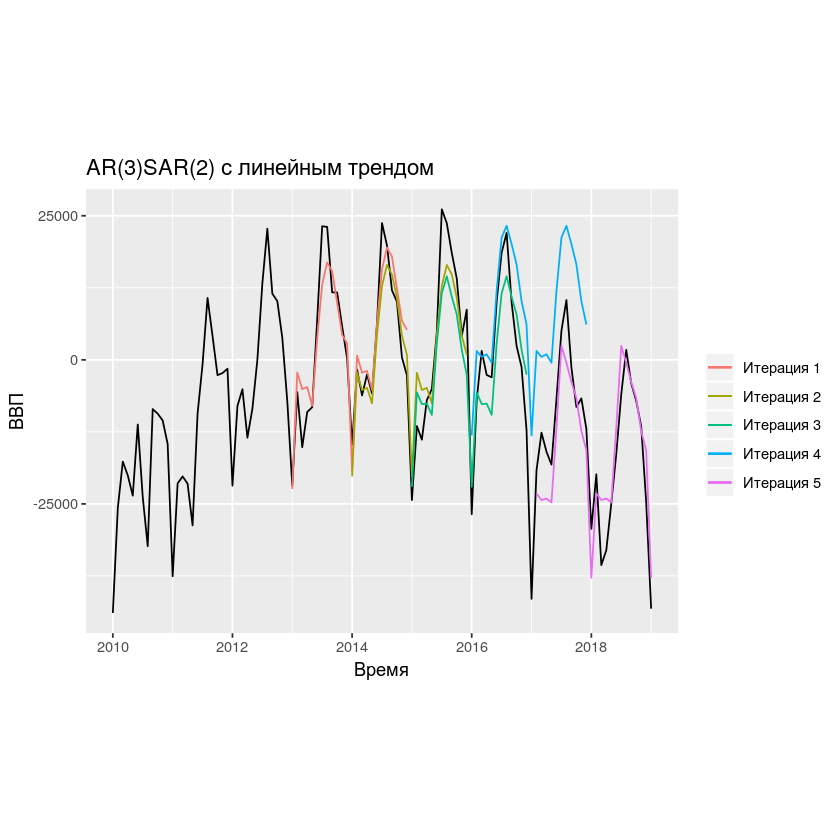

In [28]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [29]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-1839.5168  7698.9993   121.9313    25.2000

In [30]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [31]:
df_mean_acc[3,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,85.57111,309.7325,8015.222
3 level,85.22093,308.4589,7695.016
2 level (state),85.22638,308.5041,7698.999
2 level (type),84.82532,305.0175,NA
2 level (clusetered),85.17063,303.3762,NA


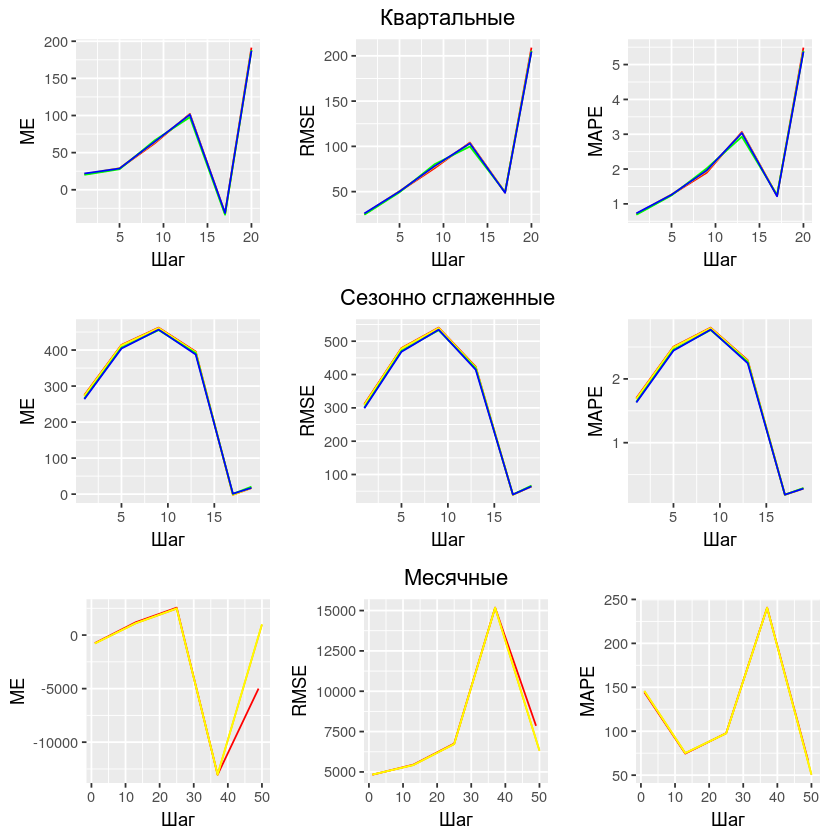

In [32]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'yellow'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [33]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_type.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [34]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [35]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [36]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- ets(msts(allts[,j], seasonal.periods = var_freq), lambda=NULL)
        
    }
    
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }
this_file_models_list[[3]]  <-  this_model_list


[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -22888.573  -2466.219  -5069.912  -4749.612  -7745.730   3826.287
 [7]  13375.849  17183.011  15434.172  10658.766   4522.716   2853.855
[13] -19524.416    840.549  -1786.713  -1544.941  -4583.162   6944.164
[19]  16467.167  20229.717  18413.600  13605.214   7397.464   5691.240
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -20095.5083  -2090.5386  -4724.5084  -4599.9038  -6616.7896   4917.7692
 [7]  14275.6293  17606.8464  15825.9513  12381.6846   5416.5819   2167.2499
[13] -18879.9253   -887.0778  -3505.8115  -3401.5420  -5418.7271   6115.2788
[19]  15492.6897  18816.1112  17017.7205  13580.7897   6590.2564   3343.5745
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -24328 -11496 -13858  -6986  -5066   4880  26123  23705
[21]  18556  14103   4114   8705
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -20519.7483  -3804.8602  -5769.3017  -5411.4417  -7608.6748   4781.7572
 [7]  14453.5114  17281.8152  13784.6628  10894.1326   4183.7112    365.3672
[13] -19187.0630  -2484.5813  -4405.8943  -4073.3573  -6273.1753   6132.8151
[19]  15875.5999  18688.1491  15163.3849  12299.8972   5521.4491   1733.4048
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -24328 -11496 -13858  -6986  -5066   4880  26123  23705  18556  14103
[11]   4114   8705 -26799  -6998   1542  -2629  -3031  10067  18591  22017
[21]  10026   2420  -1256 -12220
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -13723.4001   1168.1488    811.6622   1075.3025   -542.6712  12266.5817
 [7]  21944.9796  23963.4138  20976.7428  17347.5897  10600.4936   7091.1991
[13] -12626.1878   2254.2880   1943.4744   2179.4470    560.2273  13388.8231
[19]  23119.8293  25125.2897  22116.2292  18504.1870  11704.1159   8221.4904
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -26799  -6998   1542  -2629  -3031  10067  18591  22017  10026   2420
[11]  -1256 -12220 -41475 -19176 -12642 -15942 -18179  -6838   5045  10369
[21]  -1320  -8177  -6696 -12005
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21234.586 -21832.787 -21768.879 -22663.909  -9429.523   4349.086
 [7]   2019.773  -1693.997  -4793.747  -9851.351 -13617.286 -35540.708
[13] -20952.866 -21555.691 -21496.316 -22395.787  -9165.754   4608.590
[19]   2275.097  -1442.769  -4546.534  -9608.072 -13377.862 -35305.063
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19176 -12642 -15942 -18179  -6838   5045  10369  -1320  -8177  -6696
[11] -12005 -29346 -19876 -35619 -33053 -24949 -16354  -5987   1730  -4072
[21]  -7117 -11516 -24655 -43180


In [37]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [38]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [39]:
df_acc

ME,RMSE,MAPE,Iteration
-1057.7705,4882.389,153.58321,1
-253.7834,5158.651,87.10670,13
-476.6483,6301.274,94.00118,25
-13949.0523,16176.646,256.98025,37
-1272.2525,6428.443,39.66707,50


In [40]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -23204.1625 -24331.2091 -24076.0792 -24757.1303 -11785.8923   2426.2691
 [7]   -508.2093  -3836.5163  -6649.1785 -12358.7543 -15726.7219 -37831.6880
[13] -23204.1625 -24331.2091 -24076.0792 -24757.1303 -11785.8923   2426.2691
[19]   -508.2093  -3836.5163  -6649.1785 -12358.7543 -15726.7219 -37831.6880

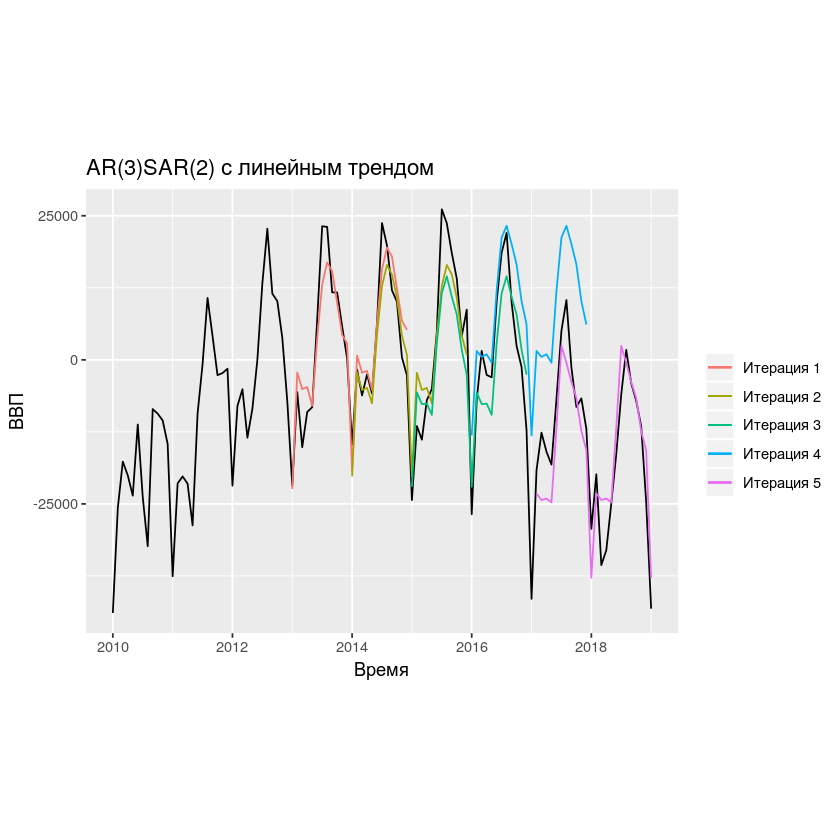

In [41]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [42]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-3401.9014  7789.4805   126.2677    25.2000

In [43]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [44]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,85.57111,309.7325,8015.222
3 level,85.22093,308.4589,7695.016
2 level (state),85.22638,308.5041,7698.999
2 level (type),84.82532,305.0175,NA
2 level (clusetered),85.17063,303.3762,NA


In [45]:
df_mean_acc[4,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,85.57111,309.7325,8015.222
3 level,85.22093,308.4589,7695.016
2 level (state),85.22638,308.5041,7698.999
2 level (type),84.82532,305.0175,7789.480
2 level (clusetered),85.17063,303.3762,NA


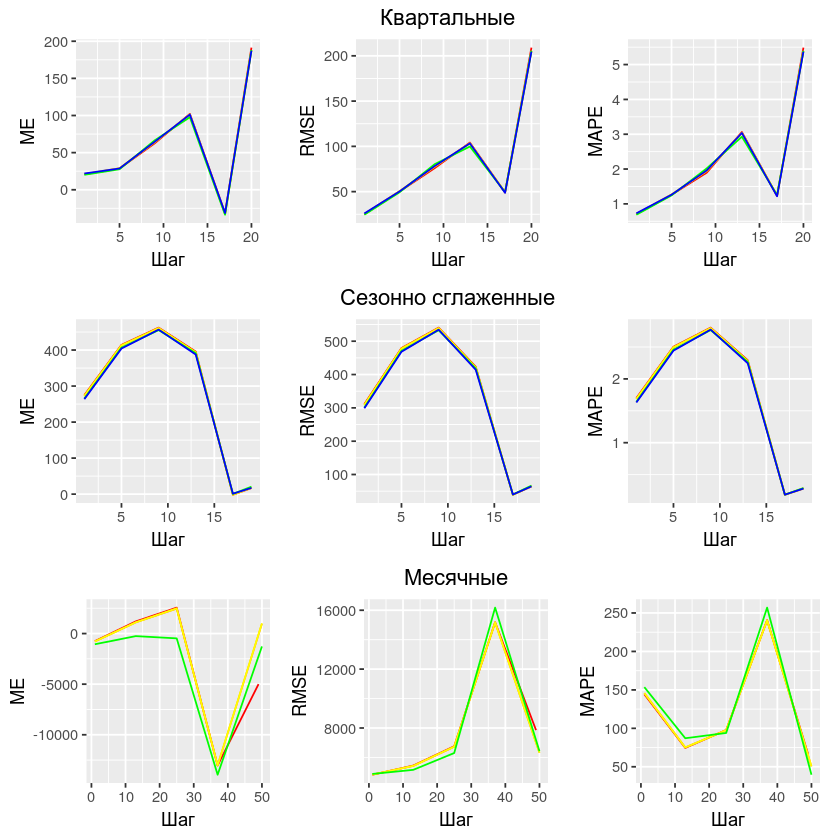

In [46]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'green'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 clust

In [47]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_clust.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [48]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [49]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [50]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- ets(msts(allts[,j], seasonal.periods = var_freq), lambda=NULL)
        
    }
    
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }
this_file_models_list[[4]]  <-  this_model_list


[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -22423.4375  -2201.7706  -4993.8807  -4709.6234  -7882.3374   3818.5547
 [7]  13228.2885  17053.1744  15464.0514  10091.2212   4454.1920   2902.0109
[13] -19335.9456    827.1229  -2012.3506  -1792.5075  -5017.3483   6632.1461
[19]  15995.4941  19769.0563  18122.5922  12704.2584   7010.8686   5413.6679
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 12

Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -20333.9865  -2313.3354  -5279.3673  -4903.6814  -7504.7372   4368.8532
 [7]  12875.0873  16544.2379  14814.7756  10880.3609   4252.0195    981.9403
[13] -20200.8103  -2181.0376  -5143.8547  -4771.2976  -7372.0543   4502.2930
[19]  13011.2493  16679.2328  14945.7660  11013.7906   4381.1918   1111.9265
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -24328 -11496 -13858  -6986  -5066   4880  26123  23705
[21]  18556  14103   4114   8705
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21831.730  -5441.889  -7412.851  -7302.988  -9296.968   3103.363
 [7]  11975.594  14882.879  11342.614   8299.708   2116.908  -2103.722
[13] -21609.055  -5221.065  -7184.374  -7078.752  -9072.643   3330.437
[19]  12214.359  15118.113  11572.740   8534.903   2340.998  -1874.185
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -24328 -11496 -13858  -6986  -5066   4880  26123  23705  18556  14103
[11]   4114   8705 -26799  -6998   1542  -2629  -3031  10067  18591  22017
[21]  10026   2420  -1256 -12220
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -13275.8559   1402.0447    508.8644    884.9267   -559.1580  11974.3615
 [7]  21306.9595  23320.7169  20143.7482  16604.6556  10159.4249   6218.3394
[13] -13115.0370   1561.4522    675.2324   1047.5401   -396.2701  12140.5304
[19]  21480.9497  23492.2590  20310.6982  16775.1593  10322.0704   6384.3267
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -26799  -6998   1542  -2629  -3031  10067  18591  22017  10026   2420
[11]  -1256 -12220 -41475 -19176 -12642 -15942 -18179  -6838   5045  10369
[21]  -1320  -8177  -6696 -12005
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -22774.84041 -23731.74418 -23568.88090 -24232.60383 -11241.09058
 [6]   2955.24857     72.20193  -3369.97790  -6156.23360 -11863.64095
[11] -15218.00147 -37293.31331 -22734.82439 -23688.54654 -23527.19781
[16] -24190.52366 -11197.29458   3001.45748    117.68737  -3327.61171
[21]  -6111.47902 -11821.63073 -15175.08131 -37253.67537
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19176 -12642 -15942 -18179  -6838   5045  10369  -1320  -8177  -6696
[11] -12005 -29346 -19876 -35619 -33053 -24949 -16354  -5987   1730  -4072
[21]  -7117 -11516 -24655 -43180


In [51]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [52]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [53]:
df_acc

ME,RMSE,MAPE,Iteration
-892.4791,4847.883,149.02032,1
1119.9349,5406.870,75.12860,13
2115.8169,6601.859,97.04018,25
-13111.4141,15271.031,241.93009,37
532.3582,6283.107,47.73417,50


In [54]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -23204.1625 -24331.2091 -24076.0792 -24757.1303 -11785.8923   2426.2691
 [7]   -508.2093  -3836.5163  -6649.1785 -12358.7543 -15726.7219 -37831.6880
[13] -23204.1625 -24331.2091 -24076.0792 -24757.1303 -11785.8923   2426.2691
[19]   -508.2093  -3836.5163  -6649.1785 -12358.7543 -15726.7219 -37831.6880

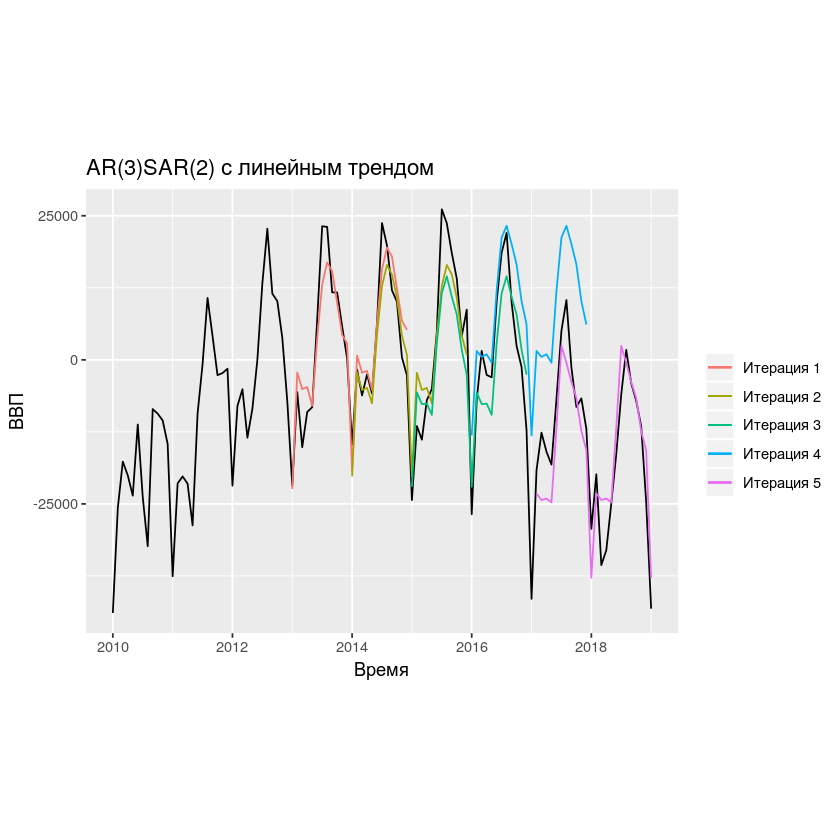

In [55]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [56]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-2047.1566  7682.1501   122.1707    25.2000

In [57]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [58]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,85.57111,309.7325,8015.222
3 level,85.22093,308.4589,7695.016
2 level (state),85.22638,308.5041,7698.999
2 level (type),84.82532,305.0175,7789.480
2 level (clusetered),85.17063,303.3762,NA


In [59]:
df_mean_acc[5,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,85.57111,309.7325,8015.222
3 level,85.22093,308.4589,7695.016
2 level (state),85.22638,308.5041,7698.999
2 level (type),84.82532,305.0175,7789.480
2 level (clusetered),85.17063,303.3762,7682.150


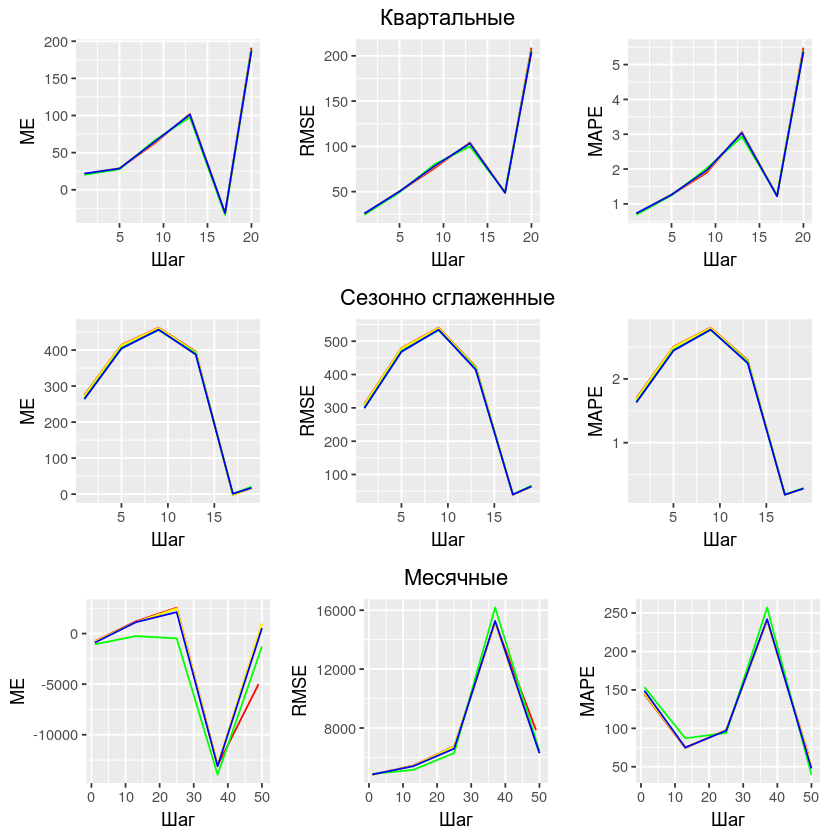

In [60]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'blue'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

In [61]:
saveRDS(df_mean_acc, "df_mean_acc_noweights.rds")
saveRDS(plots_test_all, "plots_test_not_all_noweights.rds")



In [ ]:
all_models_list <- readRDS("all_models_list.rds")
all_models_list[[3]]  <-  this_file_models_list
saveRDS(all_models_list, "all_models_list.rds")


